In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from darts import TimeSeries
from sklearn.metrics import mean_absolute_error
from darts.models import RNNModel, TransformerModel, NBEATSModel, ExponentialSmoothing, AutoARIMA
from darts.metrics import rmse, mae

import optuna
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, EarlyStopping
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Import Dataset

In [86]:
#Full initial, non-preprocessed dataset on historic data | 40 years | from openmeteo

current_dir = os.getcwd()
relative_path = os.path.dirname(current_dir)
file_name = "raw_data/historical_weather_openmeteo_01011979-08122024.csv"

file_path = os.path.join(relative_path, file_name)

df_hist_openmeteo = pd.read_csv(file_path)
df_hist_openmeteo['date'] = pd.to_datetime(df_hist_openmeteo['date'])

In [2]:
#Full non-preprocessed dataset on historic data | 15 years | from openmeteo

current_dir = os.getcwd()
relative_path = os.path.dirname(current_dir)
file_name = "raw_data/openmeteo_api_zentralstation.csv"

file_path = os.path.join(relative_path, file_name)

df_hist_openmeteo = pd.read_csv(file_path)
df_hist_openmeteo['date'] = pd.to_datetime(df_hist_openmeteo['date'])

In [20]:
#Full preprocessed dataset on historic data | 15 years | from openmeteo

current_dir = os.getcwd()
relative_path = os.path.dirname(current_dir)
file_name = "raw_data/combined_dataset.csv"

file_path = os.path.join(relative_path, file_name)

df_hist_openmeteo = pd.read_csv(file_path)
#df_hist_openmeteo['date'] = pd.to_datetime(df_hist_openmeteo['date'])

# Initial Investigations on Dataset

In [21]:
#have a look at df (with relative current data)

df_hist_openmeteo = df_hist_openmeteo.iloc[:,1:]

In [22]:
df_hist_openmeteo.head(3)

,weather_code_encoded,cloud_cover,cloud_cover_high,cloud_cover_low,cloud_cover_mid,dew_point_2m,et0_fao_evapotranspiration,precipitation,pressure_msl,rain,...,surface_pressure,temperature_2m,vapour_pressure_deficit,wind_direction_100m,wind_direction_10m,wind_gusts_10m,wind_speed_100m,wind_speed_10m,date,snowfall
0,3.0,-10.842501,72.968170,-14.7425,0.0,0.0,0.92,1025.199951,813.257202,96.0,...,0.2575,1.1575,2.6575,0.21,0.214,0.209,0.269,0.0,2009-01-01 00:00:00,0.00
1,3.0,-10.642500,73.911522,-14.3925,0.0,0.0,0.92,1025.199951,813.397522,95.0,...,0.2575,1.1075,2.6575,0.21,0.214,0.209,0.269,0.0,2009-01-01 01:00:00,0.00
2,10.0,-10.492500,74.547844,-14.1425,0.1,0.0,0.92,1025.000000,813.343994,91.0,...,0.2575,1.1075,2.6575,0.21,0.214,0.209,0.269,0.0,2009-01-01 02:00:00,0.07


In [23]:
df_hist_openmeteo.describe()

,weather_code_encoded,cloud_cover,cloud_cover_high,cloud_cover_low,cloud_cover_mid,dew_point_2m,et0_fao_evapotranspiration,precipitation,pressure_msl,rain,...,sunshine_duration,surface_pressure,temperature_2m,vapour_pressure_deficit,wind_direction_100m,wind_direction_10m,wind_gusts_10m,wind_speed_100m,wind_speed_10m,snowfall
count,50657.000000,50657.000000,50657.000000,50657.000000,50657.000000,50656.000000,50656.000000,50656.000000,50656.000000,50656.000000,...,50656.000000,50656.000000,50656.000000,50656.00000,50656.000000,50656.000000,50656.000000,50656.000000,50656.000000,50656.000000
mean,3.890854,1.806460,82.009915,-1.256687,0.186876,0.117988,0.501636,1017.037863,815.091164,68.507205,...,3.704749,3.683587,3.646256,3.58628,0.257510,0.257600,0.245303,0.285108,1253.689350,0.050373
std,3.560415,8.614114,15.400876,8.038830,0.458648,0.392530,0.534100,7.623501,8.176635,34.449516,...,5.223661,4.655830,3.781837,2.86441,0.047629,0.046196,0.049073,0.024904,1646.126214,0.165712
min,0.000000,-27.642500,20.058226,-30.342499,0.000000,0.000000,0.000000,981.000000,781.828979,0.000000,...,-2.642500,-1.242500,-0.442500,0.20750,0.176000,0.177000,0.167000,0.241000,0.000000,0.000000
25%,1.000000,-4.242500,72.870468,-6.792500,0.000000,0.000000,0.000000,1012.900024,810.060028,44.000000,...,-0.492500,-0.392500,0.207500,0.80750,0.213000,0.214000,0.199000,0.263000,0.000000,0.000000
50%,3.000000,2.007500,86.530434,-0.542500,0.000000,0.000000,0.280000,1017.599976,816.476105,83.000000,...,0.907500,1.307500,1.957500,2.75750,0.259000,0.261000,0.247000,0.288000,0.000000,0.000000
75%,5.000000,8.157499,94.150215,5.407500,0.200000,0.000000,0.990000,1021.799988,821.036774,99.000000,...,7.657500,7.907500,7.357500,6.40750,0.294000,0.294000,0.287000,0.301000,3600.000000,0.000000
max,12.000000,25.507500,100.000000,15.157499,6.300000,6.300000,1.900000,1040.599976,833.399902,100.000000,...,22.007500,16.757500,12.107500,9.10750,0.401000,0.383000,0.360000,0.353000,3600.000000,2.730000


In [24]:
df_hist_openmeteo.shape

(50657, 31)

In [25]:
print(df_hist_openmeteo['date'].is_unique)

True


In [27]:
df_hist_openmeteo['date'] = pd.to_datetime(df_hist_openmeteo['date'])
df_hist_openmeteo.dtypes

weather_code_encoded                    float64
cloud_cover                             float64
cloud_cover_high                        float64
cloud_cover_low                         float64
cloud_cover_mid                         float64
dew_point_2m                            float64
et0_fao_evapotranspiration              float64
precipitation                           float64
pressure_msl                            float64
rain                                    float64
relative_humidity_2m                    float64
snow_depth                              float64
soil_moisture_0_to_7cm                  float64
soil_moisture_100_to_255cm              float64
soil_moisture_28_to_100cm               float64
soil_moisture_7_to_28cm                 float64
soil_temperature_0_to_7cm               float64
soil_temperature_100_to_255cm           float64
soil_temperature_28_to_100cm            float64
soil_temperature_7_to_28cm              float64
sunshine_duration                       

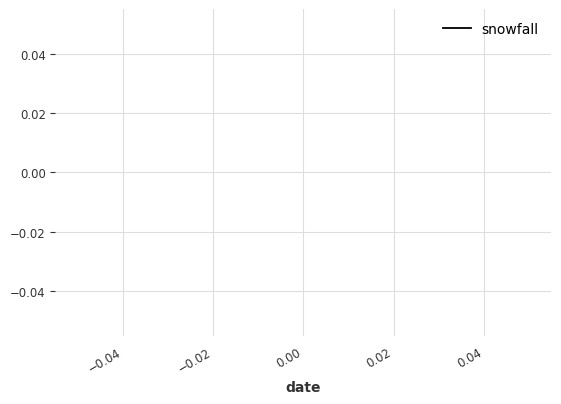

In [28]:
df_hist_openmeteo.loc[100000:].plot(y='snowfall', x='date');

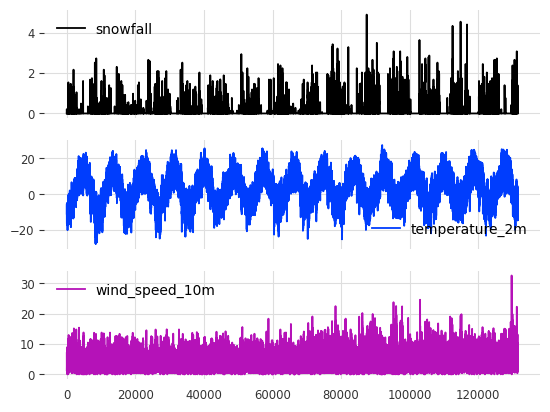

In [7]:
plot_cols = ['snowfall', 'temperature_2m', 'wind_speed_10m']
plot_features = df_hist_openmeteo[plot_cols]
plot_features.index = df_hist_openmeteo.index
plot_features.plot(subplots = True);

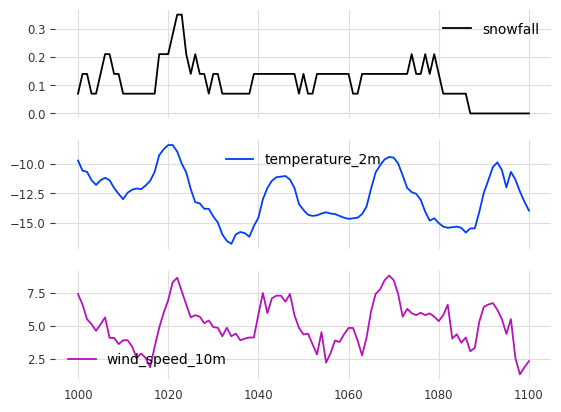

In [109]:
zoomed_slice = slice(1000,1100)

plot_features = df_hist_openmeteo.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

In [9]:
df_hist_openmeteo['date'] = df_hist_openmeteo['date'].dt.tz_localize(None)
#df_hist_openmeteo.set_index(['date'], inplace=True)
df_hist_openmeteo.tail(4)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,sunshine_duration
131492,2024-01-01 20:00:00,-14.571,86.166550,-16.371000,0.0,0.0,0.0,1.23,1.0,1017.4,...,25.919998,0.679,0.929,1.779,3.629,0.24,0.246,0.238,0.267,0.0
131493,2024-01-01 21:00:00,-14.571,84.035320,-16.671001,0.0,0.0,0.0,1.23,3.0,1017.1,...,25.560000,0.679,0.929,1.779,3.629,0.24,0.246,0.238,0.267,0.0
131494,2024-01-01 22:00:00,-13.721,80.381676,-16.371000,0.0,0.0,0.0,1.23,3.0,1016.9,...,26.280000,0.679,0.929,1.779,3.629,0.24,0.246,0.238,0.267,0.0
131495,2024-01-01 23:00:00,-13.421,78.443700,-16.371000,0.0,0.0,0.0,1.23,1.0,1015.7,...,27.000000,0.679,0.929,1.779,3.629,0.24,0.246,0.238,0.267,0.0


#### Add time lag to target variable (snowfall | up to 48 hours)

In [111]:
# target variable preparation | ensure target (=snowfall) aligns with prediction horizon  --> not necessary for RNN/ TransformerModel!
df = df_hist_openmeteo.copy()
snowfall_series_list = []
# manual, test
# df['snowfall_1h'] = df['snowfall'].shift(-1)
# df[['date','snowfall','snowfall_1h']]

# for the next 48 hours:
for i in range(1,49):
    df[f'snowfall_{i}h'] = df['snowfall'].shift(-i)
    snowfall_series_list.append(TimeSeries.from_dataframe(df, 'date', value_cols=f'snowfall_{i}h'))

df.head(3)

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,snowfall_39h,snowfall_40h,snowfall_41h,snowfall_42h,snowfall_43h,snowfall_44h,snowfall_45h,snowfall_46h,snowfall_47h,snowfall_48h
0,2009-01-01 00:00:00,-10.842501,72.968170,-14.7425,0.0,0.0,0.00,0.92,3.0,1025.2,...,0.0,0.00,0.00,0.07,0.07,0.07,0.0,0.0,0.0,0.0
1,2009-01-01 01:00:00,-10.642500,73.911520,-14.3925,0.0,0.0,0.00,0.92,3.0,1025.2,...,0.0,0.00,0.07,0.07,0.07,0.00,0.0,0.0,0.0,0.0
2,2009-01-01 02:00:00,-10.492500,74.547844,-14.1425,0.1,0.0,0.07,0.92,71.0,1025.0,...,0.0,0.07,0.07,0.07,0.00,0.00,0.0,0.0,0.0,0.0


In [112]:
len(snowfall_series_list)

48

# Time Series Preparation

In [10]:
y = df_hist_openmeteo[['snowfall']]
X = df_hist_openmeteo.drop(columns='snowfall')
X_columns = df_hist_openmeteo.drop(columns=['date','snowfall']).columns.tolist()

In [11]:
snowfall_series = TimeSeries.from_dataframe(df_hist_openmeteo, 'date', 'snowfall')
feature_series = TimeSeries.from_dataframe(df_hist_openmeteo, 'date', value_cols=X_columns)

In [143]:
snowfall_series

<TimeSeries (DataArray) (date: 131496, component: 1, sample: 1)> Size: 1MB
array([[[0.  ]],

       [[0.  ]],

       [[0.07]],

       ...,

       [[0.  ]],

       [[0.  ]],

       [[0.  ]]])
Coordinates:
  * date       (date) datetime64[ns] 1MB 2009-01-01 ... 2024-01-01T23:00:00
  * component  (component) object 8B 'snowfall'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [38]:
feature_series

<TimeSeries (DataArray) (date: 131496, component: 29, sample: 1)> Size: 31MB
array([[[-10.842501],
        [ 72.96817 ],
        [-14.7425  ],
        ...,
        [  0.209   ],
        [  0.269   ],
        [  0.      ]],

       [[-10.6425  ],
        [ 73.91152 ],
        [-14.3925  ],
        ...,
        [  0.209   ],
        [  0.269   ],
        [  0.      ]],

       [[-10.4925  ],
        [ 74.547844],
        [-14.1425  ],
        ...,
...
        ...,
        [  0.238   ],
        [  0.267   ],
        [  0.      ]],

       [[-13.721   ],
        [ 80.381676],
        [-16.371   ],
        ...,
        [  0.238   ],
        [  0.267   ],
        [  0.      ]],

       [[-13.421   ],
        [ 78.4437  ],
        [-16.371   ],
        ...,
        [  0.238   ],
        [  0.267   ],
        [  0.      ]]])
Coordinates:
  * date       (date) datetime64[ns] 1MB 2009-01-01 ... 2024-01-01T23:00:00
  * component  (component) object 232B 'temperature_2m' ... 'sunshine_duration'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

#### eventually add seasonality feature?  --> NO doesn't improve MAE

In [ ]:
# time_feature = datetime_attribute_timeseries(
#     snowfall_series, attribute="month", one_hot=True
# )

# feature_series = feature_series.stack(time_feature)
# feature_series

<TimeSeries (DataArray) (date: 131496, component: 41, sample: 1)> Size: 43MB
array([[[-10.842501],
        [ 72.96817 ],
        [-14.7425  ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-10.6425  ],
        [ 73.91152 ],
        [-14.3925  ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-10.4925  ],
        [ 74.547844],
        [-14.1425  ],
        ...,
...
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-13.721   ],
        [ 80.381676],
        [-16.371   ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-13.421   ],
        [ 78.4437  ],
        [-16.371   ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]]])
Coordinates:
  * date       (date) datetime64[ns] 1MB 2009-01-01 ... 2024-01-01T23:00:00
  * component  (component) object 328B 'temperature_2m' ... 'month_11'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Train Test Split

#### on whole dataset

In [12]:
y_train_val, y_test = snowfall_series.split_before(0.8)
y_train, y_val = y_train_val.split_before(0.7)

X_train_val, X_test = feature_series.split_before(0.8)
X_train, X_val = X_train_val.split_before(0.7)

#### on smaller dataset for faster model evaluation

In [46]:
# perform model selection with smaller dataset
df_probe = df_hist_openmeteo.iloc[100000:]
df_probe.head()

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,sunshine_duration
100000,2020-05-29 16:00:00,6.029,57.138783,-1.821,0.0,0.0,0.0,0.05,3.0,1022.7,...,40.320000,5.179,2.829,1.779,0.579,0.271,0.276,0.302,0.324,3600.0000
100001,2020-05-29 17:00:00,4.579,70.779686,-0.271,0.1,0.1,0.0,0.05,51.0,1023.5,...,39.600000,4.829,2.979,1.779,0.579,0.271,0.276,0.302,0.324,1281.4644
100002,2020-05-29 18:00:00,3.279,85.801920,1.129,0.2,0.2,0.0,0.05,51.0,1024.4,...,37.800000,4.179,3.079,1.779,0.579,0.272,0.275,0.302,0.324,1118.0491
100003,2020-05-29 19:00:00,2.079,96.146230,1.529,0.1,0.1,0.0,0.05,51.0,1024.6,...,27.000000,3.479,3.129,1.779,0.579,0.272,0.275,0.301,0.324,0.0000
100004,2020-05-29 20:00:00,0.479,99.279970,0.379,0.0,0.0,0.0,0.05,3.0,1025.1,...,20.519999,2.479,3.079,1.779,0.579,0.272,0.275,0.301,0.324,0.0000


In [14]:
probe_snowfall_series = snowfall_series[100000:]  # = 29.05.2020 - 01.01.2024
probe_feature_series = feature_series[100000:]

In [15]:
timestamp_test = pd.Timestamp('2023-11-15 00:00:00')

y_train_val_probe, y_test_probe = probe_snowfall_series.split_before(timestamp_test)
y_train_probe, y_val_probe = y_train_val_probe.split_before(0.7)

X_train_val_probe, X_test_probe = probe_feature_series.split_before(timestamp_test)
X_train_probe, X_val_probe = X_train_val_probe.split_before(0.7)

In [60]:
y_train_df = y_train_val_probe.pd_dataframe()
y_train_df.tail()

component,snowfall
date,
2023-11-14 19:00:00,0.0
2023-11-14 20:00:00,0.0
2023-11-14 21:00:00,0.0
2023-11-14 22:00:00,0.0
2023-11-14 23:00:00,0.0


In [65]:
y_test_df = y_test_probe.pd_dataframe()
y_test_df

component,snowfall
date,
2023-11-15 00:00:00,0.00
2023-11-15 01:00:00,0.00
2023-11-15 02:00:00,0.14
2023-11-15 03:00:00,0.00
2023-11-15 04:00:00,0.07
...,...
2024-01-01 19:00:00,0.00
2024-01-01 20:00:00,0.00
2024-01-01 21:00:00,0.00


In [61]:
y_test_df['snowfall'].sum()

211.25999812999999

In [18]:
print(len(y_train_val_probe))
print(len(y_test_probe))
print(len(y_test_probe)/len(y_train_val_probe))

30344
1152
0.037964671763775375


# Baseline Model

In [19]:
# Baseline model to compare
seasonal_naive_baseline = df_probe['snowfall'].shift(365)
base_pred = seasonal_naive_baseline.dropna()

mae_seasonal_naive = mean_absolute_error(y_test_probe.values(), base_pred[-len(y_test_probe):])
mae_seasonal_naive

#alternative baseline --> mean
mean_baseline = df_probe['snowfall'].mean()
mean_baseline_pred = [mean_baseline] * len(y_test_probe)

mae_mean = mean_absolute_error(y_test_probe.values(), mean_baseline_pred)  #better

print(f"naive seasonal forecasting (shifting 365 days) gives a mae of {mae_seasonal_naive} whereas a basic mean prediction leads to a mae of {mae_mean}")

naive seasonal forecasting (shifting 365 days) gives a mae of 0.29178819172743053 whereas a basic mean prediction leads to a mae of 0.19555735030216523


# Model Selection

In [16]:
model_selection = {}

#### i) RNN Model

In [163]:
model_rnn = RNNModel(
    model="LSTM",
    input_chunk_length=48,    # 48 hours input
    output_chunk_length=48,   # 48 hours output
    training_length=96,
    n_epochs=50,
    random_state=42,
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


--> Somehow only gives output_chunk_length = 1 so not suitable for predicting next 48 hours

#### ii) TransformerModel

In [45]:
model_transformer = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    n_epochs=5, # increase! just for testing
    random_state=42
)

In [46]:
history_transformer = model_transformer.fit(series=y_train_probe, past_covariates=X_train_probe, val_series=y_val_probe, val_past_covariates=X_val_probe)

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 2.0 K  | train
6 | positional_encoding | _PositionalEncoding | 0    

Epoch 4: 100%|██████████| 549/549 [01:22<00:00,  6.68it/s, train_loss=0.0325, val_loss=0.036]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 549/549 [01:22<00:00,  6.68it/s, train_loss=0.0325, val_loss=0.036]


In [61]:
transformer_forecast = model_transformer.predict(n=48, series=y_train_val_probe, past_covariates=X_train_val_probe)
transformer_forecast

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s]


<TimeSeries (DataArray) (date: 48, component: 1, sample: 1)> Size: 384B
array([[[0.51958752]],

       [[0.48111383]],

       [[0.47226423]],

       [[0.42898356]],

       [[0.36247039]],

       [[0.34737107]],

       [[0.32413891]],

       [[0.30156205]],

       [[0.32732347]],

       [[0.3390116 ]],

...

       [[0.13821028]],

       [[0.14565783]],

       [[0.14666933]],

       [[0.13089362]],

       [[0.11442618]],

       [[0.12211933]],

       [[0.14684236]],

       [[0.12131103]],

       [[0.13645603]],

       [[0.13022695]]])
Coordinates:
  * date       (date) datetime64[ns] 384B 2023-04-14T12:00:00 ... 2023-04-16T...
  * component  (component) object 8B 'snowfall'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [62]:
mae_transformer_model = mean_absolute_error(y_test_probe.values()[:48], transformer_forecast.values())
print(f"MAE TransformerModel = {mae_transformer_model}")

model_selection["TransformerModel"] = mae_transformer_model

MAE TransformerModel = 0.13741441645600405


#### iii) AutoArima

In [51]:
autoarima_model = AutoARIMA(
    seasonality=True,
    stepwise=True,
    random_state=42
)

In [ ]:
history_autoarima = autoarima_model.fit(series=y_train_val_probe)
history_autoarima

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anita/.pyenv/versions/3.10.6/envs/

In [140]:
forecast_autoarima = autoarima_model.predict(48)
forecast_autoarima

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonality']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<TimeSeries (DataArray) (date: 48, component: 1, sample: 1)> Size: 384B
array([[[0.70882304]],

       [[0.66233712]],

       [[0.6222806 ]],

       [[0.59152516]],

       [[0.5652766 ]],

       [[0.54494603]],

       [[0.5277342 ]],

       [[0.51430469]],

       [[0.5030123 ]],

       [[0.49414694]],

...

       [[0.45554135]],

       [[0.45552821]],

       [[0.45551824]],

       [[0.45551089]],

       [[0.45550564]],

       [[0.45550212]],

       [[0.45549998]],

       [[0.45549897]],

       [[0.45549887]],

       [[0.45549952]]])
Coordinates:
  * date       (date) datetime64[ns] 384B 2023-04-14T12:00:00 ... 2023-04-16T...
  * component  (component) object 8B 'snowfall'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [141]:
mae_autoarima = mean_absolute_error(y_test_probe.values()[:48], forecast_autoarima.values())
print(f"MAE AutoArima = {mae_autoarima}")

model_selection["AutoArima"] = mae_autoarima

MAE AutoArima = 0.27303774656327656


#### iv) NBEATSModel

In [142]:
nbeats_model = NBEATSModel(input_chunk_length=48, output_chunk_length=48, n_epochs=5, random_state=42)

In [143]:
history_nbeats = nbeats_model.fit(series=y_train_probe, past_covariates=X_train_probe, val_series=y_val_probe, val_past_covariates=X_val_probe)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 17.6 M | train
-------------------------------------------------------------
17.6 M    Trainable params
9.9 K     Non-trainable params
17.6 M    Total params
70.335    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 549/549 [02:16<00:00,  4.02it/s, train_loss=0.0706, val_loss=0.0921]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 549/549 [02:16<00:00,  4.02it/s, train_loss=0.0706, val_loss=0.0921]


In [144]:
nbeats_forecast= nbeats_model.predict(48)
nbeats_forecast

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


<TimeSeries (DataArray) (date: 48, component: 1, sample: 1)> Size: 384B
array([[[-0.44132349]],

       [[-0.22372217]],

       [[-0.07077036]],

       [[-0.03712443]],

       [[-0.00780588]],

       [[ 0.05907708]],

       [[ 0.06324225]],

       [[ 0.26741346]],

       [[-0.00120578]],

       [[-0.08823195]],

...

       [[ 0.24825537]],

       [[ 0.19411199]],

       [[-0.53152525]],

       [[ 0.30375783]],

       [[ 0.26290799]],

       [[ 0.19609893]],

       [[ 0.29729972]],

       [[ 0.22822937]],

       [[ 0.09476913]],

       [[-0.16566058]]])
Coordinates:
  * date       (date) datetime64[ns] 384B 2022-06-03T12:00:00 ... 2022-06-05T...
  * component  (component) object 8B 'snowfall'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [145]:
mae_nbeats_model = mean_absolute_error(y_test_probe.values()[:48], nbeats_forecast.values())
print(f"MAE NBEATSModel = {mae_nbeats_model}")

model_selection["NBEATSModel"] = mae_nbeats_model

MAE NBEATSModel = 0.24562019365211316


#### v) Exponential Smoothing

In [146]:
exponentialsmoothing_model = ExponentialSmoothing()

In [147]:
history_expsmoothing = exponentialsmoothing_model.fit(y_train_val_probe)

In [148]:
es_forecast = exponentialsmoothing_model.predict(48)
es_forecast

<TimeSeries (DataArray) (date: 48, component: 1, sample: 1)> Size: 384B
array([[[0.78252596]],

       [[0.78406083]],

       [[0.78713029]],

       [[0.78312653]],

       [[0.78152502]],

       [[0.78259179]],

       [[0.78265833]],

       [[0.78799177]],

       [[0.78725836]],

       [[0.79539169]],

...

       [[0.79386939]],

       [[0.8044695 ]],

       [[0.80946968]],

       [[0.81053631]],

       [[0.80273631]],

       [[0.7937361 ]],

       [[0.79286972]],

       [[0.7935363 ]],

       [[0.79080287]],

       [[0.78340294]]])
Coordinates:
  * date       (date) datetime64[ns] 384B 2023-04-14T12:00:00 ... 2023-04-16T...
  * component  (component) object 8B 'snowfall'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [149]:
mae_es_model = mean_absolute_error(y_test_probe.values()[:48], es_forecast.values())
print(f"MAE ExponentialSmoothing = {mae_es_model}")

model_selection["ExponentialSmoothing"] = mae_es_model

MAE ExponentialSmoothing = 0.559123028668113


In [64]:
model_selection["BaselineModel"] = mae_mean
model_selection

{'TransformerModel': 0.13741441645600405,
 "'best' TransformerModel": 0.05604817198061307,
 'BaselineModel': 0.10568119420332105}

#### Baseline Model Performs so much better 🫥 - on non-preprocessed/ scaled and limited data.... 
#### Let's try optimizing paramteres:

## Hyperparameter Optimization

In [65]:
# define objective function
def objective(trial):
    input_length = trial.suggest_int("input_length", 12,72, step=12)
    output_length = 48

    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    d_model = trial.suggest_categorical("d_model", [32, 64, 128])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    actication = trial.suggest_categorical("activation", ["relu","gelu","ReGLU"])

    es = EarlyStopping("val_loss", min_delta=0.001, patience=5, verbose=True)
    callbacks = [es]

    pl_trainer_kwargs={
        "accelerator": "auto",
        "callbacks": [es]
    }

    model = TransformerModel(
        input_chunk_length=input_length,
        output_chunk_length=output_length,
        d_model=d_model,
        dropout=dropout,
        batch_size=batch_size,
        n_epochs=5,
        pl_trainer_kwargs=pl_trainer_kwargs,
        random_state=42,
        save_checkpoints=True,
        model_name="transformer_model",
        force_reset=True
    )

    model.fit(series=y_train_probe, val_series=y_val_probe, past_covariates=X_train_probe, val_past_covariates=X_val_probe)
    model = TransformerModel.load_from_checkpoint("transformer_model")

    pred = model.predict(48, series=y_train_val, past_covariates=X_train_val)

    return mean_absolute_error(y_test_probe.values()[:48], pred.values())

In [165]:
# Run optimization  | RUN AGAIN!
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5) # try in cloud with more trials

print(f"Best trial: {study.best_trial.params}")

[I 2024-12-11 19:46:49,640] A new study created in memory with name: no-name-4ba0a66b-d688-48d6-b84d-59e03db78d93
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 

Epoch 0: 100%|██████████| 550/550 [00:55<00:00,  9.98it/s, train_loss=0.120, val_loss=0.0387]

Metric val_loss improved. New best score: 0.039


Epoch 1: 100%|██████████| 550/550 [00:53<00:00, 10.19it/s, train_loss=0.080, val_loss=0.0373]  

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.037


Epoch 4: 100%|██████████| 550/550 [00:55<00:00,  9.99it/s, train_loss=0.0874, val_loss=0.0363] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 550/550 [00:55<00:00,  9.96it/s, train_loss=0.0874, val_loss=0.0363]


/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.46it/s]

[I 2024-12-11 19:51:28,244] Trial 0 finished with value: 0.21525120211346427 and parameters: {'input_length': 12, 'dropout': 0.29852612816796115, 'd_model': 128, 'batch_size': 32, 'activation': 'gelu'}. Best is trial 0 with value: 0.21525120211346427.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 4.0 K  | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 6.2 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.597     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1096/1096 [03:01<00:00,  6.02it/s, train_loss=0.168, val_loss=0.0404]

Metric val_loss improved. New best score: 0.040


Epoch 1: 100%|██████████| 1096/1096 [02:58<00:00,  6.14it/s, train_loss=0.00969, val_loss=0.0371]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.037


Epoch 4: 100%|██████████| 1096/1096 [02:40<00:00,  6.84it/s, train_loss=0.0453, val_loss=0.0367] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1096/1096 [02:40<00:00,  6.83it/s, train_loss=0.0453, val_loss=0.0367]

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]

[I 2024-12-11 20:05:57,585] Trial 1 finished with value: 0.21275378764880892 and parameters: {'input_length': 60, 'dropout': 0.09608626082969002, 'd_model': 128, 'batch_size': 16, 'activation': 'relu'}. Best is trial 1 with value: 0.21275378764880892.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 992    | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 238 K  | train
8 | decoder             | Linear              | 1.6 K  | train
--------------------------------------------------------------------
241 K     Trainable params
0         Non-trainable params
241 K     Total params
0.966     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1098/1098 [01:06<00:00, 16.54it/s, train_loss=0.0133, val_loss=0.0373]

Metric val_loss improved. New best score: 0.037


Epoch 2: 100%|██████████| 1098/1098 [01:00<00:00, 18.25it/s, train_loss=0.0257, val_loss=0.0359]  

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.036


Epoch 4: 100%|██████████| 1098/1098 [01:01<00:00, 17.97it/s, train_loss=0.153, val_loss=0.0357]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1098/1098 [01:01<00:00, 17.95it/s, train_loss=0.153, val_loss=0.0357]


/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.43it/s]

[I 2024-12-11 20:11:08,449] Trial 2 finished with value: 0.2056713394252252 and parameters: {'input_length': 24, 'dropout': 0.06411593639729776, 'd_model': 32, 'batch_size': 16, 'activation': 'relu'}. Best is trial 2 with value: 0.2056713394252252.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 2.0 K  | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 548 K  | train
8 | decoder             | Linear              | 3.1 K  | train
--------------------------------------------------------------------
553 K     Trainable params
0         Non-trainable params
553 K     Total params
2.215     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 549/549 [00:52<00:00, 10.52it/s, train_loss=0.0499, val_loss=0.0382]

Metric val_loss improved. New best score: 0.038


Epoch 4: 100%|██████████| 549/549 [01:12<00:00,  7.57it/s, train_loss=0.115, val_loss=0.0366]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.037
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 549/549 [01:15<00:00,  7.26it/s, train_loss=0.115, val_loss=0.0366]

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.09it/s]

[I 2024-12-11 20:15:50,903] Trial 3 finished with value: 0.21909717104893023 and parameters: {'input_length': 24, 'dropout': 0.2789839001416609, 'd_model': 64, 'batch_size': 32, 'activation': 'relu'}. Best is trial 2 with value: 0.2056713394252252.
/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 4.0 K  | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 1.4 M  | train
8 | decoder             | Linear              | 6.2 K  | train
--------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.597     Total estimated model params 

Epoch 0: 100%|██████████| 549/549 [02:03<00:00,  4.45it/s, train_loss=0.214, val_loss=0.0416]

Metric val_loss improved. New best score: 0.042


Epoch 1: 100%|██████████| 549/549 [02:06<00:00,  4.36it/s, train_loss=0.0021, val_loss=0.0385] 

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.038


Epoch 2: 100%|██████████| 549/549 [01:56<00:00,  4.72it/s, train_loss=0.021, val_loss=0.037]   

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.037


Epoch 4: 100%|██████████| 549/549 [01:59<00:00,  4.60it/s, train_loss=0.0021, val_loss=0.037]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 549/549 [01:59<00:00,  4.60it/s, train_loss=0.0021, val_loss=0.037]


/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.22it/s]

[I 2024-12-11 20:25:51,869] Trial 4 finished with value: 0.21417471136940422 and parameters: {'input_length': 48, 'dropout': 0.09001698850030136, 'd_model': 128, 'batch_size': 32, 'activation': 'ReGLU'}. Best is trial 2 with value: 0.2056713394252252.



Best trial: {'input_length': 24, 'dropout': 0.06411593639729776, 'd_model': 32, 'batch_size': 16, 'activation': 'relu'}


In [166]:
print(study.best_value)
print(f"Best trial: {study.best_trial.params}")

0.2056713394252252
Best trial: {'input_length': 24, 'dropout': 0.06411593639729776, 'd_model': 32, 'batch_size': 16, 'activation': 'relu'}


# Currently # "Best" Model

In [20]:
from datetime import datetime

current_dir = os.getcwd()
relative_path = os.path.join(os.path.dirname(current_dir),"models")
file_name = f"TransformerModel_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
file_path = os.path.join(relative_path,file_name)
file_path

'/home/anita/code/MadMax1995bb/powder_alert2.0/models/TransformerModel_2024-12-13_12:03:06.pt'

In [21]:
from pytorch_lightning import Callback

class MetricsCallback(Callback):
    def on_validation_epoch_end(self, trainer, pl_module):

        val_mae = trainer.callback_metrics.get('val_loss')
        trainer.logger.log_metrics({"val_mae": val_mae}, step=trainer.current_epoch)

In [22]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

csv_logger = CSVLogger(save_dir=relative_path, name="snowfall_transformer_csv_logs")
tb_logger = TensorBoardLogger(save_dir=relative_path, name="snowfall_transformer_tb_logs")

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode='min',
)

pl_trainer_kwargs = {
    "accelerator": "auto",
    "callbacks":[es, MetricsCallback()],
    "logger": [csv_logger, tb_logger],
    "log_every_n_steps": 1,
}

best_model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    dropout=0.0641,
    d_model=32,
    batch_size=16,
    activation="relu",
    n_epochs=10, # increase! just for testing
    pl_trainer_kwargs=pl_trainer_kwargs,
    random_state=42,
    model_name=file_name,
    save_checkpoints=True,
    work_dir=relative_path,
    force_reset=False
)

In [23]:
# fit on partial dataset for faster computation
best_model.fit(series=y_train_probe, val_series=y_val_probe, past_covariates=X_train_probe, val_past_covariates=X_val_probe)

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 992    | train
6 | positional_encoding | _PositionalEncoding | 0    

Epoch 9: 100%|██████████| 1322/1322 [01:58<00:00, 11.15it/s, v_num=0, train_loss=0.0307, val_loss=0.0436]      

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1322/1322 [01:58<00:00, 11.15it/s, v_num=0, train_loss=0.0307, val_loss=0.0436]


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.0641, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=16, n_epochs=10, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f0b1762f280>, <__main__.MetricsCallback object at 0x7f0b1762f220>], 'logger': [<pytorch_lightning.loggers.csv_logs.CSVLogger object at 0x7f0b1762d000>, <pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f0b1762f910>], 'log_every_n_steps': 1}, random_state=42, model_name=TransformerModel_2024-12-13_12:03:06.pt, save_checkpoints=True, work_dir=/home/anita/code/MadMax1995bb/powder_alert2.0/models, force_reset=False)

In [ ]:
#whole dataset fit
best_model.fit(series=y_train, val_series=y_val, past_covariates=X_train, val_past_covariates=X_val)

/home/anita/.pyenv/versions/3.10.6/envs/powder_alert2.0/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 992    | train
6 | positional_encoding | _PositionalEncoding | 0    

Epoch 8: 100%|██████████| 4597/4597 [05:42<00:00, 13.44it/s, v_num=0, train_loss=0.00077, val_loss=0.0527]   


TransformerModel(output_chunk_shift=0, d_model=32, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.0641, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=16, n_epochs=10, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f74e07a0940>], 'logger': <pytorch_lightning.loggers.tensorboard.TensorBoardLogger object at 0x7f74e07a29e0>}, random_state=42, model_name=TransformerModel_2024-12-13_08:22:01.pt, save_checkpoints=True, work_dir=/home/anita/code/MadMax1995bb/powder_alert2.0/models, force_reset=False)

In [ ]:
y_train_val

In [72]:
forecast = best_model.predict(n=48, series=y_train_val_probe, past_covariates=X_train_val_probe)
print(f"Snow forecast for the next hour: {forecast.values()[0][0]} cm")
print(len(forecast.values()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.37it/s]
Snow forecast for the next hour: -0.016610706683274568 cm
48


In [76]:
y_test_df.head()

component,snowfall
date,
2023-11-15 00:00:00,0.00
2023-11-15 01:00:00,0.00
2023-11-15 02:00:00,0.14
2023-11-15 03:00:00,0.00
2023-11-15 04:00:00,0.07


In [77]:
forecast.pd_dataframe().head()

component,snowfall
date,
2023-11-15 00:00:00,-0.016611
2023-11-15 01:00:00,-0.005112
2023-11-15 02:00:00,0.008059
2023-11-15 03:00:00,0.016528
2023-11-15 04:00:00,0.026477


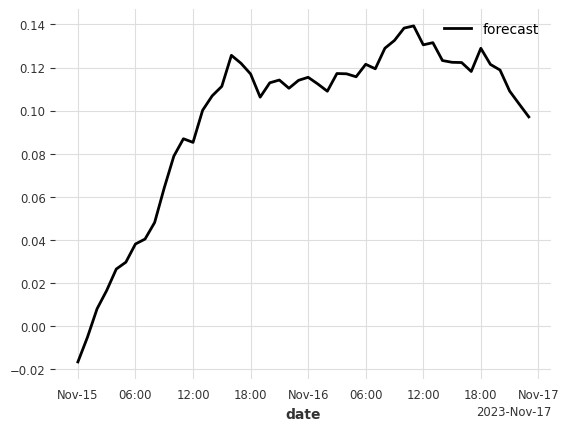

In [79]:
real_snowfall_48 = y_test_df['snowfall'][:48]
#real_snowfall_48.plot(label="real_snowfall")
forecast.plot(label="forecast");

In [27]:
mae_best_model = mean_absolute_error(y_test.values()[:48], forecast.values())
print(f"MAE 'best' TransformerModel = {mae_best_model}")

MAE 'best' TransformerModel = 0.04804337518761059


In [20]:
#Load saved model

model_file = "TransformerModel_2024-12-13_08:22:01.pt"
model_path = os.path.join(relative_path,model_file)

trained_model = TransformerModel.load_from_checkpoint(model_path)
trained_model

: 

### Learning Curves

In [166]:
trained_model.predict(n=48)
print(f"Snow forecast for the next hour: {forecast.values()[0][0]} cm")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.00it/s]
Snow forecast for the next hour: 0.022329610140609968 cm


In [182]:
trained_model.trainer.logged_metrics

{}

In [26]:
best_model.trainer.logged_metrics

{}

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

if "train_loss" in metrics_df or "val_loss" in metrics_df:
    axes[0].plot(metrics_df.get("train_loss", []), label="Training Loss", color="blue")
    axes[0].plot(metrics_df.get("val_loss", []), label="Validation Loss", color="orange")
    axes[0].set_title("Loss Learning Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

if "train_mae" in metrics_df or "val_mae" in metrics_df:
    axes[1].plot(metrics_df.get("train_mae", []), label="Training MAE", color="blue")
    axes[1].plot(metrics_df.get("val_mae", []), label="Validation MAE", color="orange")
    axes[1].set_title("MAE Learning Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("MAE")
    axes[1].legend()

plt.show()

### Backtesting

In [81]:
backtest_results = best_model.backtest(
    series = y_train_val,
    past_covariates = X_train_val,
    start = 0.7,
    forecast_horizon = 48,
    stride=10,
    metric= mean_absolute_error,
    overlap_end=True,
    retrain=False
)

print(f"MAE from backtesting optimized TransformerModel: {backtest_results}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


: 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


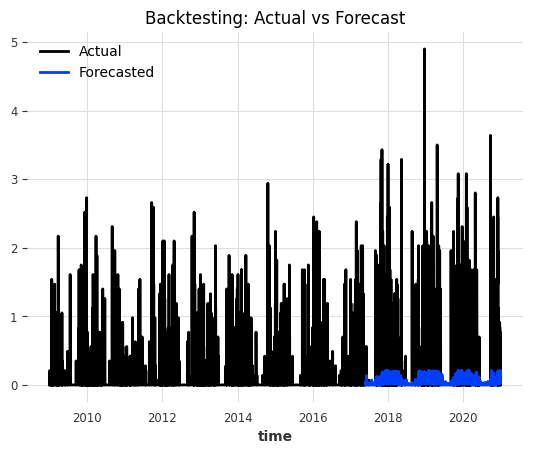

In [28]:
preds = best_model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
)

# Plot actual snowfall and forecast
y_train_val.plot(label="Actual")
preds.plot(label="Forecasted")
plt.legend()
plt.title("Backtesting: Actual vs Forecast")
plt.show()

In [ ]:
mae = mean_absolute_error(y_test_probe.values(), preds.values())
print(f"MAE current 'best' TransformerModel = {mae}")

: 